In [1]:
import warnings

import matplotlib_inline.backend_inline
import seaborn as sns

warnings.filterwarnings("ignore")  # Ignore warnings for the purpose of this tutorial

sns.set_style(style="white")
sns.set_context("talk")
matplotlib_inline.backend_inline.set_matplotlib_formats("png", dpi=200)

# Estimate cascade rates from structure functions

This example will demonstrate how to estimate cascade rates from two different velocity-based structure functions. Cascade rate estimations depend on the physical constraints of the turbulent system and this example specifically applies to 2D quasi-geostrophic fluid dynamics. 

**General procedure:**

1. Set up plot environment & load/format the data
2. Calculate structure functions for all snapshots of the simulation
3. Bootstrap to generate a mean
4. Estimate cascade rates
5. Plot cascade rates as a function of length scale

### Download sample dataset with Pooch
We will use [Pooch](https://github.com/fatiando/pooch) to download a sample dataset.

In [2]:
import pooch

file_path = pooch.retrieve(
    url="https://zenodo.org/records/15278227/files/2layer_128.jld2",
    known_hash="a04abc602ca3bbc4ff9a868a96848b6815a17f697202fb12e3ff40762de92ec6")

## Initialize the data
We will use `h5py` to load a `.jld2` file, the output from [GeophysicalFlows.jl](https://fourierflows.github.io/GeophysicalFlowsDocumentation/stable/), a numerical ocean simulator written in Julia. The data consists of 2D (horizontal) fields simulated over a periodic domain. There are multiple snapshots of this data, corresponding to different times. We will select the last snapshot to analyze.

In [3]:
import h5py

f = h5py.File(file_path, "r")
grid = f["grid"]
snapshots = f["snapshots"]

# Initialize the grid of x and y coordinates
x = grid["x"][()]
y = grid["y"][()]

# Grab u and v for all snapshots and layers (we will just use the top layer)
u = snapshots['u']
v = snapshots['v']

Make a couple of quick plots of the top layer at the last timestep to see the velocity fields.

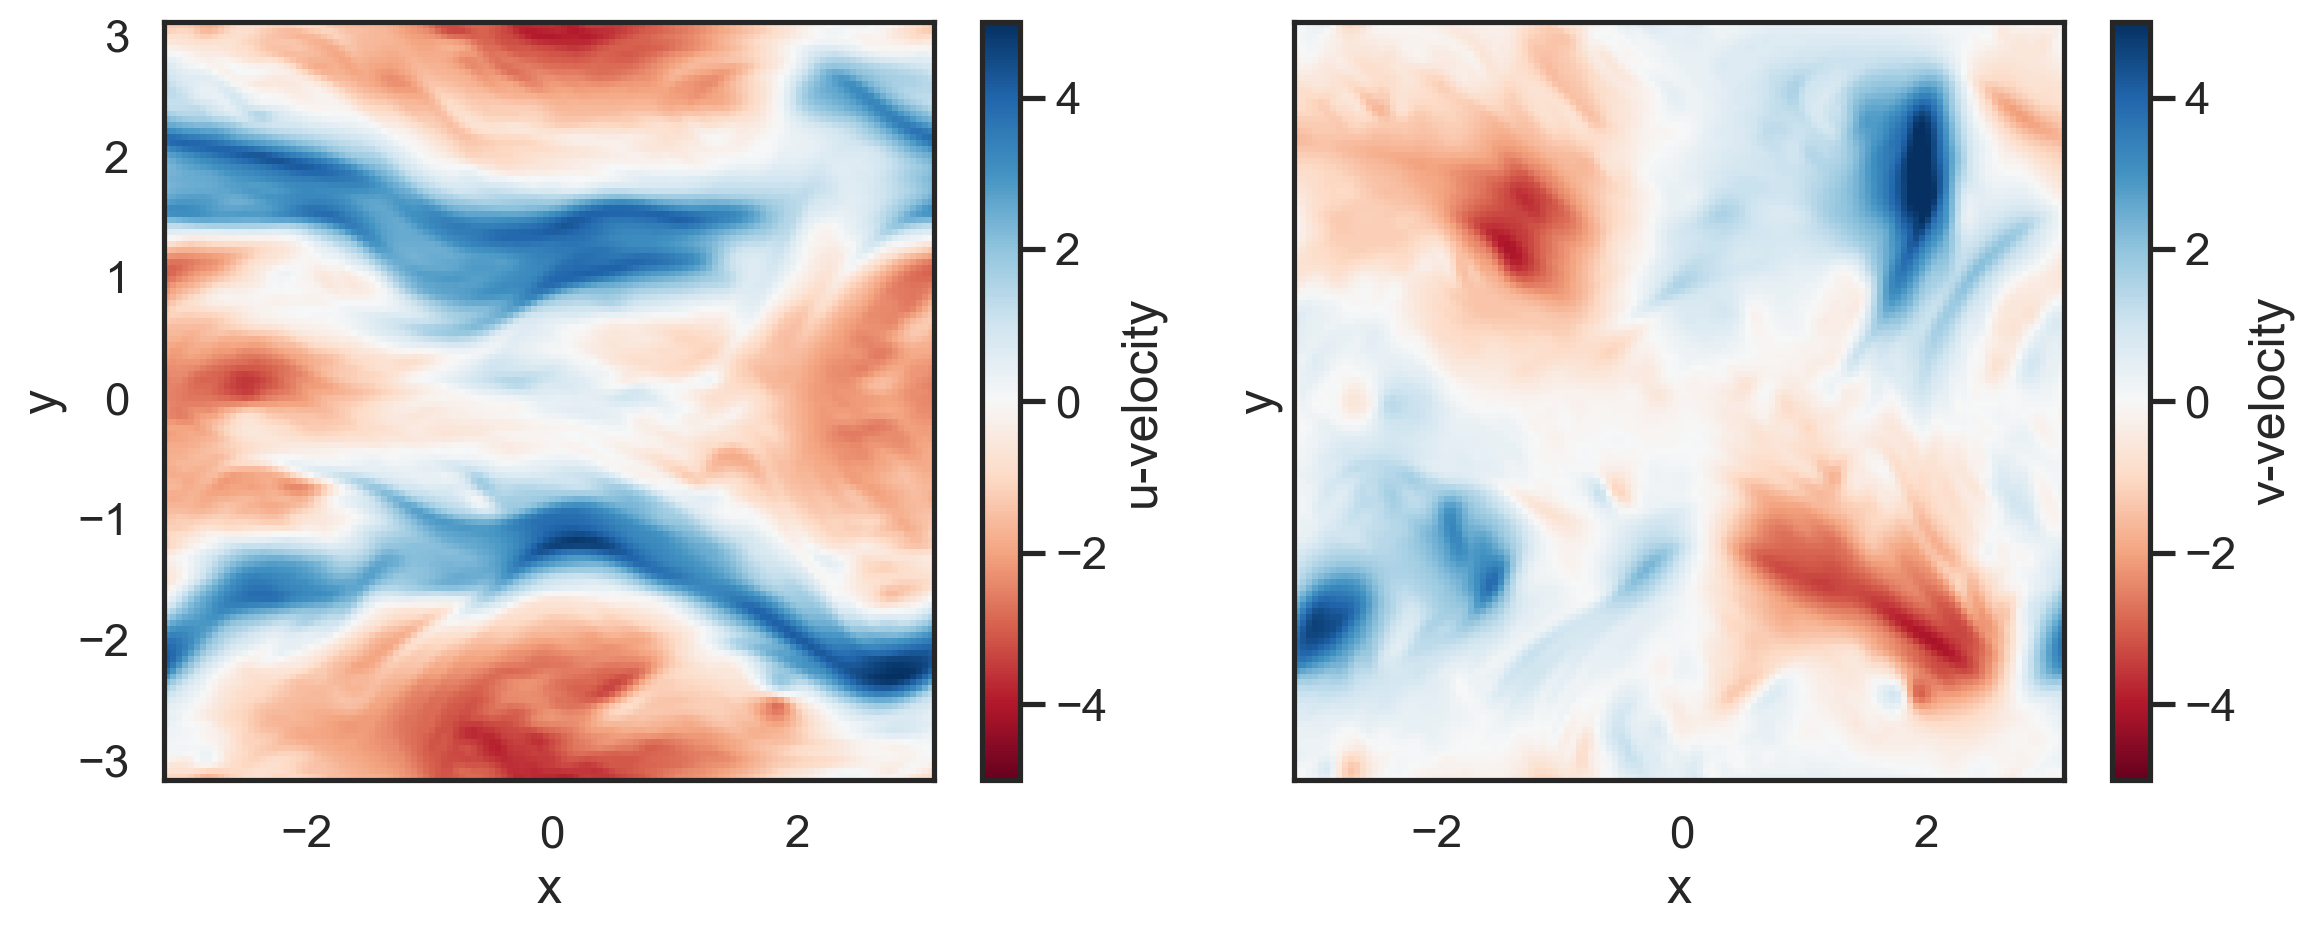

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,5))
p1 = ax1.pcolormesh(x,y,u['20050'][0], cmap='RdBu',vmin=-5,vmax=5)
p2 = ax2.pcolormesh(x,y,v['20050'][0], cmap='RdBu',vmin=-5,vmax=5)
fig.colorbar(p1,label='u-velocity')
fig.colorbar(p2, label='v-velocity')
ax1.set_xlabel('x')
ax2.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_ylabel('y')
plt.tight_layout()

## Calculate structure functions for all snapshots

Here we will calculate the advective velocity structure function and the third order longitudinal velocity structure function. We will calculate each structure function in the x-direction and the y-direction for a total of four unique structure functions.

In [5]:
import fluidsf

sfs_list = [
    fluidsf.generate_structure_functions_2d(
        u[d][0],
        v[d][0],
        x,
        y,
        sf_type=["ASF_V", "LLL"],
        boundary="periodic-all",
    )
    for d in u.keys()
]

## Bootstrap structure functions

We are using [scipy's bootstrapping method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html) here, though other methods of estimating error and variability are possible. We will use a confidence level of 90%. 

In [6]:
import numpy as np
from scipy.stats import bootstrap

# Reformat single sfs_list for ease of boostrapping
sf_ASF_x = []
sf_ASF_y = []
sf_LLL_x = []
sf_LLL_y = []

for sf in sfs_list:
    sf_ASF_x.append(sf["SF_advection_velocity_x"])
    sf_ASF_y.append(sf["SF_advection_velocity_y"])
    sf_LLL_x.append(sf["SF_LLL_x"])
    sf_LLL_y.append(sf["SF_LLL_y"])

# Bootstrap the structure functions with 90% confidence levels
boot_ASF_x = bootstrap((sf_ASF_x,), np.mean, confidence_level=0.5, axis=0)
boot_ASF_y = bootstrap((sf_ASF_y,), np.mean, confidence_level=0.5, axis=0)
boot_LLL_x = bootstrap((sf_LLL_x,), np.mean, confidence_level=0.5, axis=0)
boot_LLL_y = bootstrap((sf_LLL_y,), np.mean, confidence_level=0.5, axis=0)

# Generate the confidence intervals for structure functions, still at 90%
boot_ASF_x_conf = boot_ASF_x.confidence_interval
boot_ASF_y_conf = boot_ASF_y.confidence_interval
boot_LLL_x_conf = boot_LLL_x.confidence_interval
boot_LLL_y_conf = boot_LLL_y.confidence_interval

# Compute the mean -- this can also be accomplished with a Python mean function 
# and will return the same result
boot_ASF_x_mean = boot_ASF_x.bootstrap_distribution.mean(axis=1)
boot_ASF_y_mean = boot_ASF_y.bootstrap_distribution.mean(axis=1)
boot_LLL_x_mean = boot_LLL_x.bootstrap_distribution.mean(axis=1)
boot_LLL_y_mean = boot_LLL_y.bootstrap_distribution.mean(axis=1)

## Estimate cascade rates

Different types of structure functions have different relationships to properties of turbulent flow, including cascade rates (inter-scale fluxes). Both velocity structure functions we have calculated can be related to the inverse energy cascade present in 2D turbulent systems. For more details about structure functions and their relevance to fluid properties, see the section [What are structure functions?](https://cassidymwagner.github.io/fluidsf/sfs.html)

The advective velocity structure function (`SF_advection_velocity` or $ASF_v$) and the third order longitudinal velocity structure function (`SF_LLL` or $SF_v^3$) have the following relationships with the inverse energy cascade rate in a 2D quasi-geostrophic system:

$\epsilon = -2 SF^3_v /3\mathbf{r}$

$\epsilon = - ASF_v /2$

where $\mathbf{r}$ is an array of separation differences (`x-diffs` or `y-diffs` in this case).

Now we can estimate the cascade rates using both structure functions.

In [7]:
epsilon_LLL_x_mean = - 2 * boot_LLL_x_mean / (3 * sfs_list[0]['x-diffs'])
epsilon_LLL_y_mean = - 2 * boot_LLL_y_mean / (3 * sfs_list[0]['y-diffs'])
epsilon_ASF_x_mean = - boot_ASF_x_mean / 2
epsilon_ASF_y_mean = - boot_ASF_y_mean / 2

## Plot cascade rates and compare


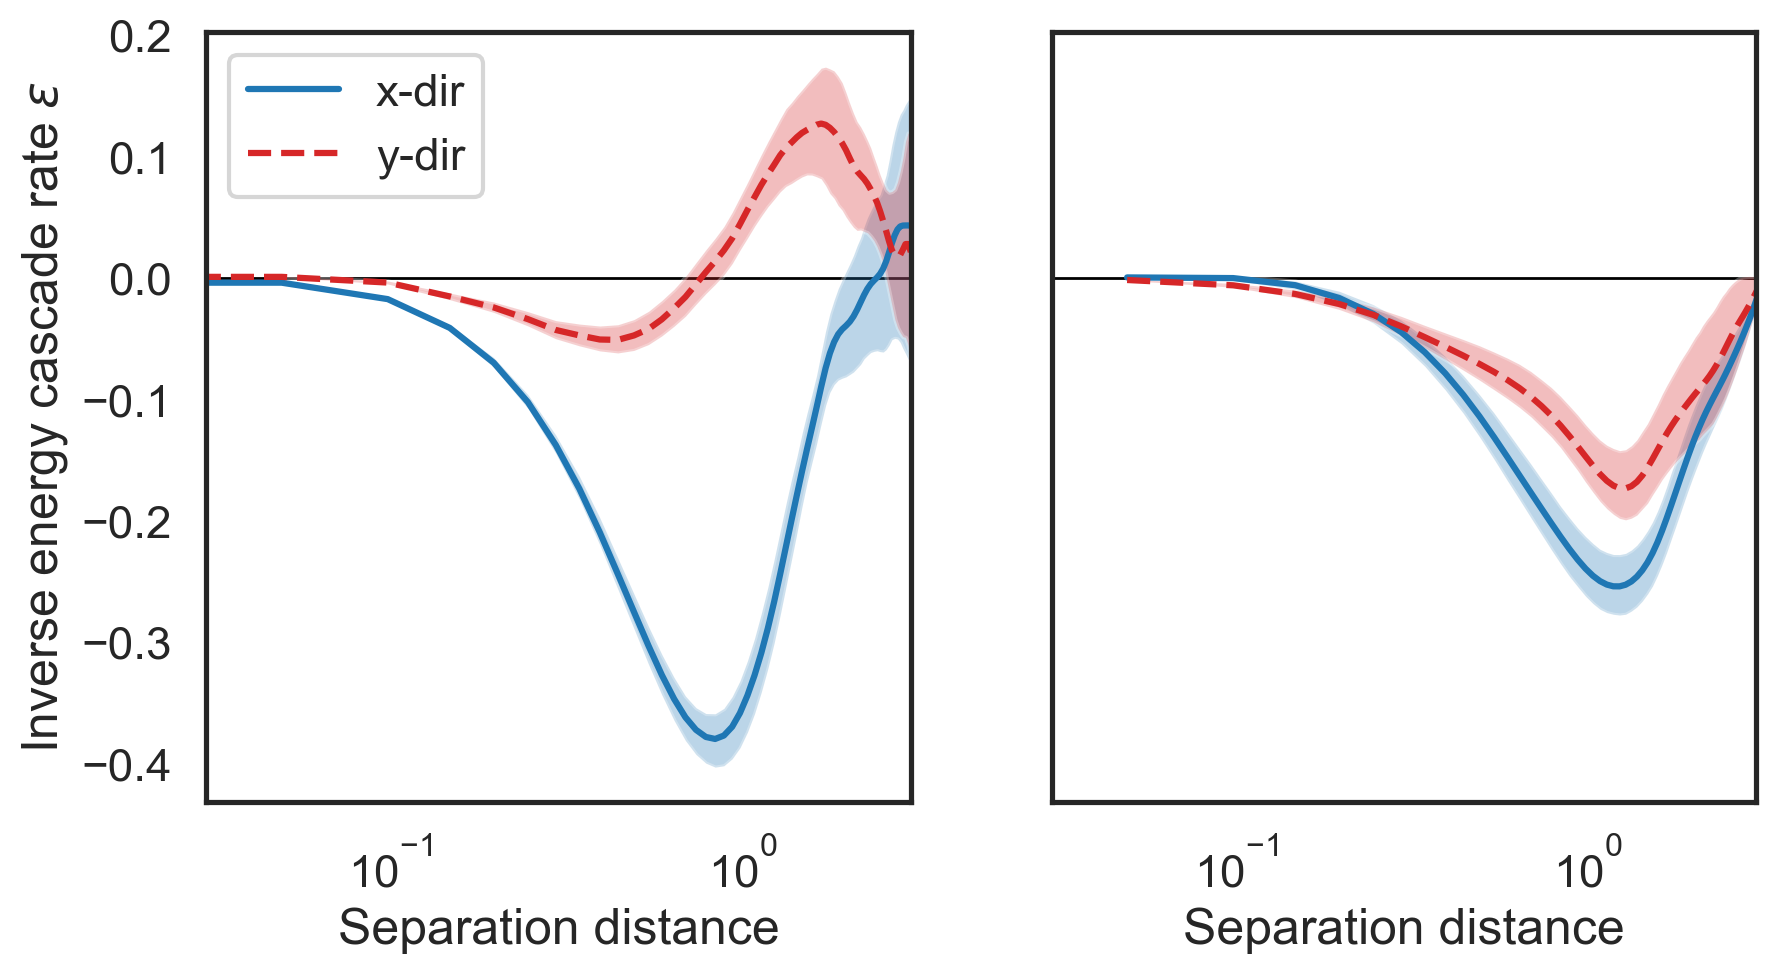

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)

ax2.semilogx(
    sfs_list[0]["x-diffs"], epsilon_LLL_x_mean, label=r"LLL$_x$", color="tab:blue"
)
ax2.semilogx(
    sfs_list[0]["y-diffs"],
    epsilon_LLL_y_mean,
    label=r"LLL$_y$",
    color="tab:red",
    linestyle="dashed",
)
ax1.semilogx(
    sfs_list[0]["x-diffs"], epsilon_ASF_x_mean, label=r"x-dir", color="tab:blue"
)
ax1.semilogx(
    sfs_list[0]["y-diffs"],
    epsilon_ASF_y_mean,
    label=r"y-dir",
    color="tab:red",
    linestyle="dashed",
)

# Shade in the confidence regions
ax1.fill_between(
    sfs_list[0]["x-diffs"],
    -boot_ASF_x_conf[0] / 2,
    -boot_ASF_x_conf[1] / 2,
    color="tab:blue",
    alpha=0.3,
    edgecolor=None,
)
ax1.fill_between(
    sfs_list[0]["y-diffs"],
    -boot_ASF_y_conf[0] / 2,
    -boot_ASF_y_conf[1] / 2,
    color="tab:red",
    alpha=0.3,
    edgecolor=None,
)
ax2.fill_between(
    sfs_list[0]["x-diffs"],
    -2 * boot_LLL_x_conf[0] / (3 * sfs_list[0]["x-diffs"]),
    -2 * boot_LLL_x_conf[1] / (3 * sfs_list[0]["x-diffs"]),
    color="tab:blue",
    alpha=0.3,
    edgecolor=None,
)
ax2.fill_between(
    sfs_list[0]["y-diffs"],
    -2 * boot_LLL_y_conf[0] / (3 * sfs_list[0]["y-diffs"]),
    -2 * boot_LLL_y_conf[1] / (3 * sfs_list[0]["y-diffs"]),
    color="tab:red",
    alpha=0.3,
    edgecolor=None,
)

ax1.set_ylabel(r"Inverse energy cascade rate $\epsilon$")
ax1.set_xlabel(r"Separation distance")
ax2.set_xlabel(r"Separation distance")
ax1.set_xlim(3e-2, 3e0)
ax2.set_xlim(3e-2, 3e0)
ax1.legend()
ax1.hlines(0, 3e-2, 3e0, color="k", lw=1, zorder=0)
ax2.hlines(0, 3e-2, 3e0, color="k", lw=1, zorder=0);